<a href="https://colab.research.google.com/github/Derun-Chai/Assignment1/blob/https%2Fgithub.com%2FAlocinYerv%2FTulip.git/Copy_of_cifar_10_cnn_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Convolutional Neural Networks by PyTorch

This tutorial covers the following topics:

- Downloading an image dataset from web URL
- Understanding convolution and pooling layers
- Creating a convolutional neural network (CNN) using PyTorch
- Training a CNN from scratch and monitoring performance
- Underfitting, overfitting and how to overcome them

### How to run the code


#### Option 1: Running using free online resources (1-click, recommended)

The easiest way to start executing the code is to click the **Run** button at the top of this page and select **Run on Colab**. [Google Colab](https://colab.research.google.com) is a free online platform for running Jupyter notebooks using Google's cloud infrastructure. You can also select "Run on Binder" or "Run on Kaggle" if you face issues running the notebook on Google Colab.


#### Option 2: Running on your computer locally

To run the code on your computer locally, you'll need to set up [Python](https://www.python.org), download the notebook and install the required libraries. We recommend using the [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) distribution of Python. Click the **Run** button at the top of this page, select the **Run Locally** option, and follow the instructions.

### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

## Exploring the CIFAR10 Dataset

For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


In [11]:
import os
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize

In [12]:
train_transform = transforms.Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the training and test sets
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=train_transform)

# Split the dataset into training and validation
val_size = 5000
train_size = len(trainset) - val_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create data loaders
batch_size = 32  # Adjust this based on your computational resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [13]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

Label: ship (8)


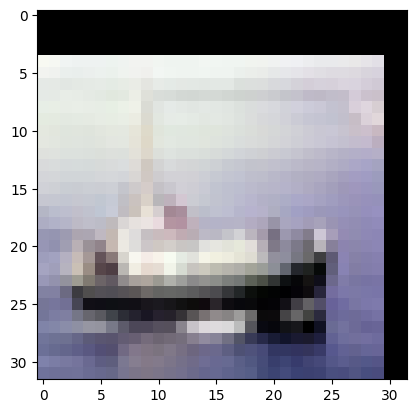

Label: horse (7)


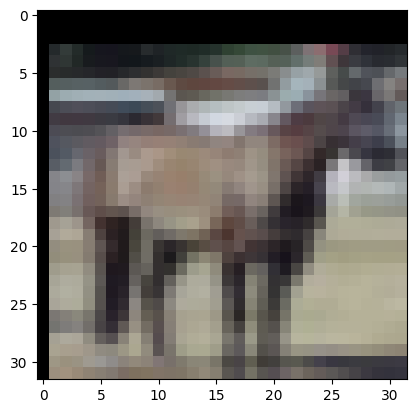

In [14]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def display_images(loader, num_images=2):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    for i in range(num_images):
        print(f"Label: {classes[labels[i]]} ({labels[i]})")
        imshow(images[i])

# Display 2 images from the training loader as an example
display_images(train_loader, 2)


## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [15]:
random_seed = 70
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [16]:
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])


We can now create data loaders for training and validation, to load the data in batches

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [19]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def denormalize(images):
    return images * 0.5 + 0.5

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images)
        ax.imshow(make_grid(denorm_images, nrow=16).permute(1, 2, 0))
        break
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri - rk + 1, ci - ck + 1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

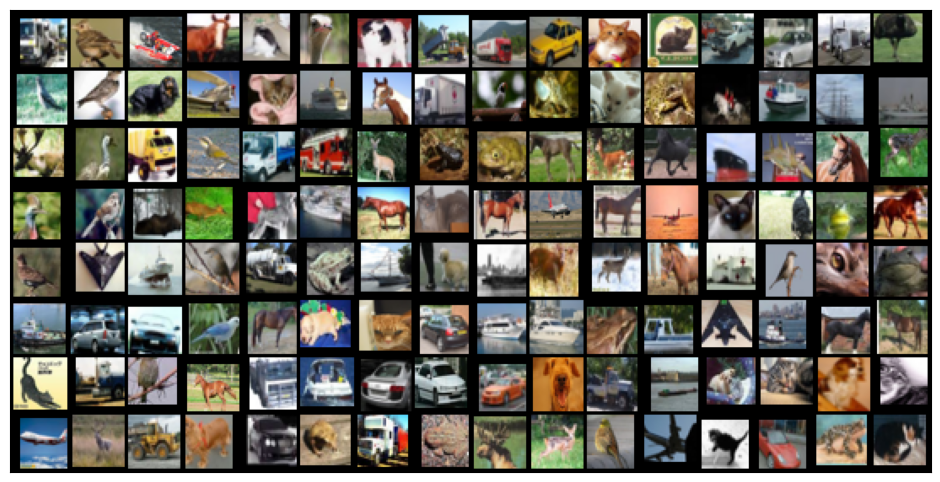

In [21]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

For this tutorial, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [22]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

output_image = apply_kernel(sample_image, sample_kernel)
print(output_image)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])


For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise.

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), # Convolutional layer
    nn.MaxPool2d(2, 2) # Max pooling layer
)

Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`.    

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      images, labels = batch
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      acc = accuracy(out, labels)         # Calculate accuracy
      return {'loss': loss, 'acc': acc}


    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [27]:
class VGG_CIFAR10(ImageClassificationBase):
    def __init__(self, variant='vgg16'):
        super(VGG_CIFAR10, self).__init__()
        # Load the pre-trained VGG model
        if variant == 'vgg16':
            self.features = models.vgg16(pretrained=False).features
        elif variant == 'vgg19':
            self.features = models.vgg19(pretrained=False).features
        # ... add other variants as needed

        # Modify the classifier for CIFAR-10 (10 classes)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [28]:
import torchvision.models as models
model = VGG_CIFAR10(variant='vgg16')
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG_CIFAR10(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [29]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0010,  0.0186, -0.0026, -0.0398,  0.0580, -0.0156, -0.0225,  0.0156,
        -0.0135, -0.0410], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [31]:
device = get_default_device()
print("Using device:", device)

Using device: cuda


We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [32]:
to_device(model, device);

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [38]:
from torch.optim.lr_scheduler import StepLR
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

from torch.optim import SGD, Adam, RMSprop

def fit(epochs, lr, model, train_loader, val_loader, optimizer_name):
    history = []

    optimizers = {
        'SGD': SGD(model.parameters(), lr=lr, momentum=0.9,  weight_decay=5e-4),
        'Adam': Adam(model.parameters(), lr=lr),
        'RMSprop': RMSprop(model.parameters(), lr=lr, alpha=0.99)
    }
    optimizer = optimizers.get(optimizer_name)
    if optimizer is None:
        raise ValueError("Optimizer not recognized. Choose from ['SGD', 'Adam', 'RMSprop']")

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(epochs):
        result = {}
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            output = model.training_step(batch)
            loss = output['loss']
            acc = output['acc']

            train_losses.append(loss)
            train_accuracies.append(acc)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        scheduler.step()  # Update the learning rate

        val_result = evaluate(model, val_loader)
        result.update(val_result)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()

        model.epoch_end(epoch, result)
        history.append(result)
    return history


Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [40]:
import torch.optim as optim
device = get_default_device()
vgg_model = VGG_CIFAR10(variant='vgg16')
vgg_model = to_device(vgg_model, device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Training with different optimizers
history_sgd = fit(10, 0.035, vgg_model, train_dl, val_dl, optimizer_name='SGD')
history_adam = fit(10, 0.035, vgg_model, train_dl, val_dl, optimizer_name='Adam')
history_rmsprop = fit(10, 0.035, vgg_model, train_dl, val_dl, optimizer_name='RMSprop')


Epoch [0], train_loss: 2.0725, train_acc: 0.1959, val_loss: 1.9085, val_acc: 0.2478
Epoch [1], train_loss: 1.7262, train_acc: 0.3318, val_loss: 1.5718, val_acc: 0.3925
Epoch [2], train_loss: 1.4749, train_acc: 0.4499, val_loss: 1.4046, val_acc: 0.4907
Epoch [3], train_loss: 1.2553, train_acc: 0.5501, val_loss: 1.1328, val_acc: 0.5848
Epoch [4], train_loss: 1.0555, train_acc: 0.6302, val_loss: 1.0250, val_acc: 0.6429
Epoch [5], train_loss: 0.9174, train_acc: 0.6851, val_loss: 0.9274, val_acc: 0.6795
Epoch [6], train_loss: 0.8422, train_acc: 0.7157, val_loss: 0.7926, val_acc: 0.7397
Epoch [7], train_loss: 0.7642, train_acc: 0.7444, val_loss: 0.7281, val_acc: 0.7508
Epoch [8], train_loss: 0.7007, train_acc: 0.7666, val_loss: 0.7770, val_acc: 0.7446
Epoch [9], train_loss: 0.6500, train_acc: 0.7863, val_loss: 0.6826, val_acc: 0.7718
Epoch [0], train_loss: 58414071808.0000, train_acc: 0.1016, val_loss: 2.3033, val_acc: 0.1001
Epoch [1], train_loss: 11100979.0000, train_acc: 0.1015, val_loss:

In [46]:
histories = {
    'SGD': history_sgd,
    'Adam': history_adam,
    'RMSprop': history_rmsprop
}

best_optimizer = None
best_accuracy = 0

for opt, history in histories.items():
    final_val_acc = history[-1]['val_acc']
    print(f"{opt} final validation accuracy: {final_val_acc:.4f}")
    if final_val_acc > best_accuracy:
        best_accuracy = final_val_acc
        best_optimizer = opt

print(f"The best optimizer is {best_optimizer} with a validation accuracy of {best_accuracy:.4f}.")


SGD final validation accuracy: 0.7718
Adam final validation accuracy: 0.0995
RMSprop final validation accuracy: 0.1048
The best optimizer is SGD with a validation accuracy of 0.7718.


The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time.

We can also plot the valdation set accuracies to study how the model improves over time.

In [47]:
def plot_accuracies(history_sgd):
    accuracies = [x['val_acc'] for x in history_sgd]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

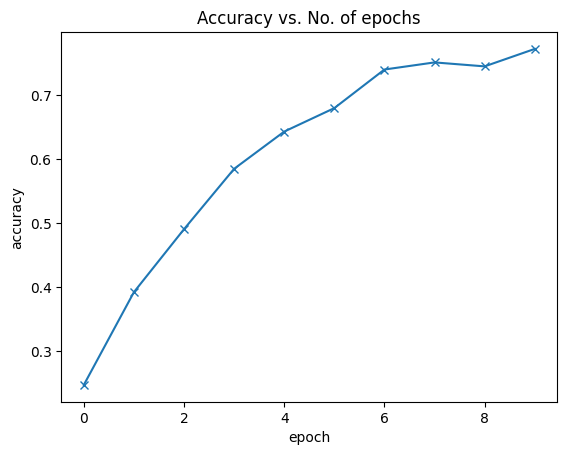

In [48]:
plot_accuracies(history_sgd)

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [49]:
def plot_losses(history_sgd):
    train_losses = [x.get('train_loss') for x in history_sgd]
    val_losses = [x['val_loss'] for x in history_sgd]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

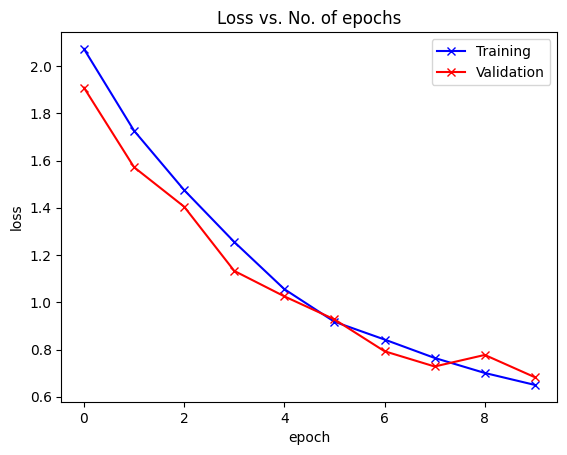

In [50]:
plot_losses(history_sgd)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

We will cover these topics in more detail in the next tutorial in this series, and learn how we can reach an accuracy of **over 90%** by making minor but important changes to our model.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.



In [62]:
testset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())



Files already downloaded and verified


Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [61]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return testset.classes[preds[0].item()]

def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean


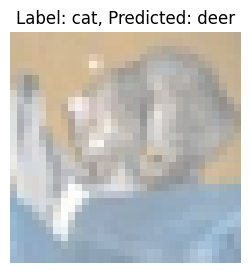

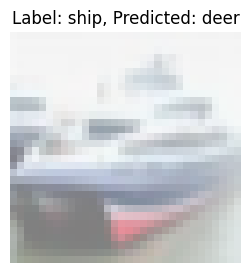

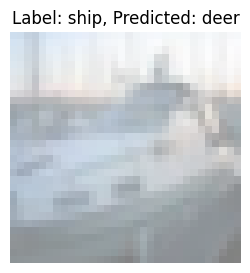

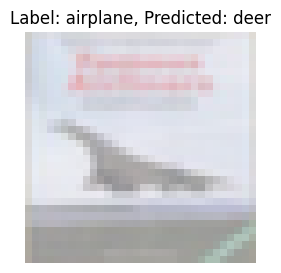

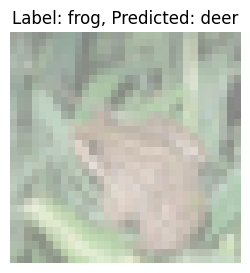

In [63]:
num_images = 5
for i in range(num_images):
    img, label = testset[i]
    plt.figure(figsize=(3,3))
    plt.imshow(denormalize(img).permute(1, 2, 0).clamp(0, 1))
    plt.title(f'Label: {testset.classes[label]}, Predicted: {predict_image(img, model)}')
    plt.axis('off')
    plt.show()


AttributeError: ignored

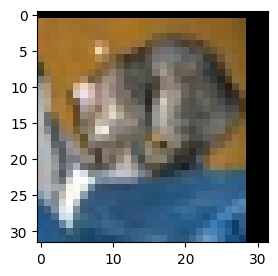

In [53]:
def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean

num_images = 5
for i in range(num_images):
    img, label = testset[i]
    plt.figure(figsize=(3,3))
    plt.imshow(denormalize(img).permute(1, 2, 0).clamp(0, 1))
    plt.title(f'Label: {datasets.classes[label]}, Predicted: {predict_image(img, model)}')
    plt.axis('off')
    plt.show()


Label: ship , Predicted: deer


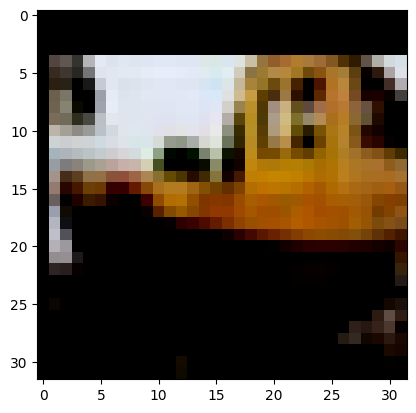

In [43]:
img, label = testset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: deer , Predicted: deer


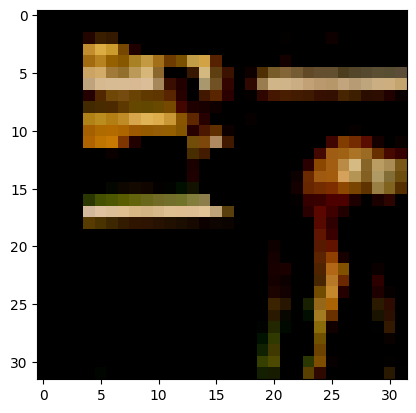

In [44]:
img, label = testset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [45]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.3032073974609375, 'val_acc': 0.09765625}

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), 'VGG_CIFAR10.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [ ]:
model2 = to_device(VGG_CIFAR10(), device)

In [ ]:
model2.load_state_dict(torch.load('VGG_CIFAR10.pth'))

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
evaluate(model2, test_loader)

## Summary and Further Reading/Exercises

We've covered a lot of ground in this tutorial. Here's quick recap of the topics:
* Introduction to the CIFAR10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers
* Capturing dataset information, metrics and hyperparameters
* Training a convolutional neural network and visualizing the losses and errors
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set
* Saving and loading the model weights, and attaching them to the eperiment

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:
* Try chaging the hyperparameters to achieve a higher accuracy within fewer epochs.
* Try adding more convolutional layers, or increasing the number of channels in each convolutional layer
* Try using a feedforward neural network and see what's the maximum accuracy you can achieve
* Read about some of the startegies mentioned above for reducing overfitting and achieving better results, and try to implement them by looking into the PyTorch docs.
* Modify this notebook to train a model for a different dataset (e.g. CIFAR100 or ImageNet)

In the next tutorial, we will continue to improve our model's accuracy using techniques like data augmentation, batch normalization and dropout. We will also learn about residual networks (or ResNets), a small but critical change to the model architecture that will significantly boost the performance of our model. Stay tuned!